# **Sentiment Analysis for hospitals comment**

---

# **Import and install library**

In [0]:
!pip install googletrans
!pip install tqdm --upgrade
!pip install twython

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=04dc74a6e7b8a71140a907736b859e18d53dda355b61e24ec847802e3d1730e7
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans
     |████████████████████████████████| 61kB 1.8MB/s 
  Found existing installation: tqdm 4.38.0
    Uninstalling tqdm-4.38.0:
      Successfully uninstalled tqdm-4.38.0


In [0]:
# web scraping
import requests
from bs4 import BeautifulSoup
from time import time, sleep
from random import randint

# Translation
from googletrans import Translator

# Utilities
from tqdm import tqdm
import numpy as np
import pandas as pd

# NLP
from nltk import sent_tokenize, word_tokenize, pos_tag, RegexpParser
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Data Splitting
from sklearn.model_selection import train_test_split

# Mount Drive
from google.colab import drive
import os

# Model and Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import hamming_loss

# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot

In [0]:
# Download resources
import nltk

nltk.download("punkt")
nltk.download("vader_lexicon")
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

---

# **Web Scraping**

ดึงข้อมูล comment การใช้บริการของโรงพยาบาล โดย Project นี้ เลือก 3 โรงพยาบาล คือ
1. โรงพยาบาล พญาไท 1
2. โรงพยาบาล พญาไท 2
3. โรงพยาบาล พญาไท 3


สร้าง function สำหรับดึงข้อมูล comment และ scores จาก website https://www.honestdocs.com และนำข้อมูลที่ได้สร้างเป็น dataframe โดยเพิ่ม field ชื่อโรงพยาลบาลด้วย

In [0]:
#Function Scraping data from https://www.honestdocs.com by hospital name.
def honestdoc_comment(url, hospitalName):
    """
    This function is to scrap data from a webboard (https://www.honestdocs.com).
    """
    #create connection
    data = requests.get(url)
    print("requests code : {}".format(data.status_code)) 
    print("note\n2xx: success\n4xx, 5xx: error")
    
    #scrape comment and score
    start_time = time() #start scraping data from page1
    r = requests.get(url, params=dict(query="web scraping",page=1)) 
    soup = BeautifulSoup(r.text,"html.parser")
    n = len(soup.find_all("div",{"class":"comments__content"})) #find n of items in the page
    
    #extract each item
    comment = [soup.find_all("div",
                             {"class":"comments__content"})[i].get_text().strip() for i in range(0,n)]
    score = [soup.find_all("span",
                           {"class":"stars star-rating"})[i].attrs["data-score"] for i in range(0,n)]
    elapsed_time = time() - start_time #finish scraping data from page1
    print("Time used for scraping data from page - 1 : {} s".format(elapsed_time))
    sleep(randint(1,3)) #mimic human behavior
           
    p = 2 #start scraping data from page2
    while n > 0: #until the number of items in a page = 0
        start_time = time() 
        r = requests.get(url, params=dict(query="web scraping",page=p))
        soup = BeautifulSoup(r.text,"html.parser")
        n = len(soup.find_all("div",{"class":"comments__content"}))
        [comment.append(soup.find_all("div",
                                      {"class":"comments__content"})[i].get_text().strip()) for i in range(0,n)]
        [score.append(soup.find_all("span",
                                    {"class":"stars star-rating"})[i].attrs["data-score"]) for i in range(0,n)]
        elapsed_time = time() - start_time
        print("Time used for scraping data from page - {} : {} s".format(p, elapsed_time))
        p +=1
        sleep(randint(1,3))

    #create dataframe
    df = pd.DataFrame({"comment": comment, 
              "score": score
              })
    #create field hospital name
    df["hospital"] = hospitalName
    
    return df

สร้าง function สำหรับแปล comment จากภาษาไทยเป็นภาษาอังกฤษ โดยเพิ่ม คำสั่ง try except สำหรับกรณีที่ api ไม่สามารถแปล comment ได้ให้ใส่ค่า "" ลงไป

In [0]:
#Function translate comment from thai to english.
def th2en(comment):
  try:
    textTrans = Translator().translate(comment, src="th", dest="en").text
  except:
    textTrans = ""
    print("\n Can not translate " + comment)

  return textTrans

เรียก function "honestdoc_comment" ดึง comment ของโรงพยาบาล พญาไท 1

In [0]:
df = honestdoc_comment(r"https://www.honestdocs.co/hospitals/phyathai-1-hospital", "phyathai-1")

requests code : 200
note
2xx: success
4xx, 5xx: error
Time used for scraping data from page - 1 : 0.9154551029205322 s
Time used for scraping data from page - 2 : 1.0356099605560303 s
Time used for scraping data from page - 3 : 0.9637758731842041 s
Time used for scraping data from page - 4 : 0.9701895713806152 s
Time used for scraping data from page - 5 : 1.0737156867980957 s
Time used for scraping data from page - 6 : 0.9093160629272461 s
Time used for scraping data from page - 7 : 0.9092979431152344 s
Time used for scraping data from page - 8 : 0.9304187297821045 s
Time used for scraping data from page - 9 : 0.910057783126831 s
Time used for scraping data from page - 10 : 0.907353401184082 s
Time used for scraping data from page - 11 : 0.9536032676696777 s
Time used for scraping data from page - 12 : 0.8932785987854004 s
Time used for scraping data from page - 13 : 0.8967010974884033 s
Time used for scraping data from page - 14 : 0.926243782043457 s
Time used for scraping data from p

นำ comment ของโรงพยาบาล พญาไท 1 มาเข้า function "th2en" เพื่อแปลภาษาเป็นภาษาอังกฤษลง column "en"

In [0]:
tqdm.pandas()
df["en"] = df.progress_apply(lambda x: th2en(x["comment"]), axis=1)

comments = df

100%|██████████| 172/172 [00:54<00:00,  3.16it/s]


เรียก function "honestdoc_comment" ดึง comment ของโรงพยาบาล พญาไท 2

In [0]:
df = honestdoc_comment(r"https://www.honestdocs.co/hospitals/phyathai-2-hospital", "phyathai-2")

requests code : 200
note
2xx: success
4xx, 5xx: error
Time used for scraping data from page - 1 : 0.913698673248291 s
Time used for scraping data from page - 2 : 0.885138988494873 s
Time used for scraping data from page - 3 : 0.8959445953369141 s
Time used for scraping data from page - 4 : 0.8955190181732178 s
Time used for scraping data from page - 5 : 0.9114391803741455 s
Time used for scraping data from page - 6 : 0.903972864151001 s
Time used for scraping data from page - 7 : 0.9013888835906982 s
Time used for scraping data from page - 8 : 0.8913519382476807 s
Time used for scraping data from page - 9 : 1.0048437118530273 s
Time used for scraping data from page - 10 : 0.919856071472168 s
Time used for scraping data from page - 11 : 1.1562674045562744 s
Time used for scraping data from page - 12 : 0.8906285762786865 s
Time used for scraping data from page - 13 : 0.9020779132843018 s
Time used for scraping data from page - 14 : 0.9017984867095947 s
Time used for scraping data from pa

นำ comment ของโรงพยาบาล พญาไท 2 มาเข้า function "th2en" เพื่อแปลภาษาเป็นภาษาอังกฤษลง column "en"

In [0]:
tqdm.pandas()
df["en"] = df.progress_apply(lambda x: th2en(x["comment"]), axis=1)

comments = comments.append(df, ignore_index=True)

100%|██████████| 96/96 [00:33<00:00,  2.86it/s]


เรียก function "honestdoc_comment" ดึง comment ของโรงพยาบาล พญาไท 3

In [0]:
df = honestdoc_comment(r"https://www.honestdocs.co/hospitals/phyathai-3-hospital", "phyathai-3")

requests code : 200
note
2xx: success
4xx, 5xx: error
Time used for scraping data from page - 1 : 0.9041399955749512 s
Time used for scraping data from page - 2 : 0.8865668773651123 s
Time used for scraping data from page - 3 : 0.8950741291046143 s
Time used for scraping data from page - 4 : 0.8874173164367676 s
Time used for scraping data from page - 5 : 0.9028360843658447 s
Time used for scraping data from page - 6 : 0.8984453678131104 s
Time used for scraping data from page - 7 : 0.9044396877288818 s
Time used for scraping data from page - 8 : 0.8974313735961914 s
Time used for scraping data from page - 9 : 0.9000258445739746 s
Time used for scraping data from page - 10 : 0.8981845378875732 s
Time used for scraping data from page - 11 : 0.9129681587219238 s
Time used for scraping data from page - 12 : 0.9107224941253662 s
Time used for scraping data from page - 13 : 0.9027559757232666 s
Time used for scraping data from page - 14 : 0.8897132873535156 s
Time used for scraping data fro

นำ comment ของโรงพยาบาล พญาไท 3 มาเข้า function "th2en" เพื่อแปลภาษาเป็นภาษาอังกฤษลง column "en"
(comment พบ error 1 comment ที่ไม่สามารถแปลได้)

In [0]:
tqdm.pandas()
df["en"] = df.progress_apply(lambda x: th2en(x["comment"]), axis=1)

comments = comments.append(df, ignore_index=True)

  3%|▎         | 5/166 [00:00<00:13, 11.92it/s]


 Can not translate แม่เราเคยเป็นลมในห้องน้ำตอนตี 2 แล้วเค้าปวดหลังมาก เลยต้องหามส่งโรงพยาบาลตอนนั้นเลย ไปถึงหมอที่ห้องฉุกเฉินก้ฉีดยาแก้ปวดให้ พอเช้าก็ให้เลือกห้องพัก รพ.เห็นแม่เรามีบัตรประกัน 3 ใบ ก็จดมาให้เลยห้องคืนละ6พันกว่าบาทไม่รวมอาหาร 3 มื้อ แม่เราเลยแจ้งว่าไม่เอาอาหารเพราะแม่เราไม่ชอบอาหารโรงพยาบาลแต่พอถึงเวลามื้อเช้าก็มีอาหารมาให้แม่ก้เลยกินพอสายๆ หมอประจำก็มาอยู่แผนกกระดูก เข้ามาตรวจแล้วบอกว่าต้องทำกายภาพ แม่เราก็ถามหมอว่าต้องทำกี่วัน หมอตอบมาว่าก็แล้วแต่คนไข้คิดว่าจะทำกี่วันหละ แม่ถามอีกว่าต้องอยู่โรงพยาบาลกี่วันหมอก็ตอบมาว่าแล้วคนไข้คิดว่าจะอยู่กี่วันหละ เราปรี๊ดมากเลยแต่แม่ห้ามเราไว้ แล้วพอวันต่อมาแม่ก็นั่งรอจน 9 โมงกว่าแม่บอกเราว่า รพ.ยังไม่เอาข้าวมาให้กินเลย เราไปถึงก็ไปถามที่เค้าเตอร์พยาบาลเค้าบอกว่าเราแจ้งเค้าว่าไม่รับอาหาร เราเลยตอบไปว่าแล้วเมื่อวานเอามาให้ทั้งที่แจ้งไปแล้วคือจะเอายังไงกันแน่จนป่านนี้ยังไม่ได้กินข้าวกินยาแล้วต้องไปกายภาพอีก ค่าห้องค่าหมอต่อคืนเกือบหมื่นแต่หมอมาดูอาการแควันละครั้งๆละไม่ถึง10นาที แย่ยิ่งกว่าประกันสังคมที่มาเช้า กลางวัน เย็นซะอีกพยาบาลก็

100%|██████████| 166/166 [00:57<00:00,  2.88it/s]


ได้ comment ทั้งหมด 434 row

In [0]:
comments.shape

(434, 4)

เรียกดู comment ที่ไม่สามารถแปลภาษาได้ พบ 1 row

In [0]:
comments[comments["en"] == ""]

,comment,score,hospital,en
270,แม่เราเคยเป็นลมในห้องน้ำตอนตี 2 แล้วเค้าปวดหลั...,1,phyathai-3,


ลบ row ที่ไม่สามารถแปลภาษาได้

In [0]:
commentsNotNAN = comments[comments["en"] != ""]

หลังจากลบ row ที่ไม่สามารถแปลภาษาได้ ข้อมูลเหลือ 433 row

In [0]:
commentsNotNAN.shape

(433, 4)

กรุ๊ป และนับข้อมูล comment ตามชื่อโรงพยาบาล

In [0]:
commentsNotNAN["hospital"].value_counts()

phyathai-1    172
phyathai-3    165
phyathai-2     96
Name: hospital, dtype: int64

ทดลองเรียกดูข้อมูลหลังจากแปลภาษาแล้ว

In [0]:
commentsNotNAN.head()

,comment,score,hospital,en
0,ซื้อแพ็กเกจ ตรวจคัดกรองมะเร็งปากมดลูก ThinPrep...,5,phyathai-1,Packages ThinPrep cervical cancer screening at...
1,บริการดีมากค่ะ ทั้งการบริการที่สะดวกรวดเร็วจึง...,4,phyathai-1,"Very good service The service friendly, making..."
2,การให้บริการเยี่ยมมากกก หมอดีมากเพราะใช้ประกัน...,5,phyathai-1,Very good service Doctor is great because the ...
3,การให้บริการดีเยี่ยม...เจ้าหน้าที่ทุกคนจะให้คว...,4,phyathai-1,Providing an excellent staff ... everyone will...
4,คุณแม่เคยเข้ารับการรักษาโดยการส่องกล้องที่กะเพ...,5,phyathai-1,Have you ever been treated by endoscopic and c...


Mount drive ใน google drive เพื่อ save ข้อมูล

In [0]:
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/DS532_Text_Analytics/Project/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Save ข้อมูลเป็น file CSV เพื่อสามารถเรียกใช้ ข้อมูลจาก file นี้ได้เลยโดยไม่ต้องดึงข้อมูลใหม่

In [0]:
#backup data 
commentsNotNAN.to_csv("comment_phyathai-1-2-3_hospital.csv", index=False)

---

# **Text preprocessing**

จัดการข้อมูล comment ที่ได้มากเพื่อเตรียมสำหรับการสร้าง Sentiment Analysis Model

ดึงข้อมูล comment ที่ได้ Save ไว้

In [0]:
data = pd.read_csv("comment_phyathai-1-2-3_hospital.csv")

ตรวจสอบจำนวนข้อมูล

In [0]:
data.shape

(433, 4)

ทดสอบเรียกดูข้อมูลที่ดึงจากไฟล์ที่ Save

In [0]:
data.head()

,comment,score,hospital,en
0,ซื้อแพ็กเกจ ตรวจคัดกรองมะเร็งปากมดลูก ThinPrep...,5,phyathai-1,Packages ThinPrep cervical cancer screening at...
1,บริการดีมากค่ะ ทั้งการบริการที่สะดวกรวดเร็วจึง...,4,phyathai-1,"Very good service The service friendly, making..."
2,การให้บริการเยี่ยมมากกก หมอดีมากเพราะใช้ประกัน...,5,phyathai-1,Very good service Doctor is great because the ...
3,การให้บริการดีเยี่ยม...เจ้าหน้าที่ทุกคนจะให้คว...,4,phyathai-1,Providing an excellent staff ... everyone will...
4,คุณแม่เคยเข้ารับการรักษาโดยการส่องกล้องที่กะเพ...,5,phyathai-1,Have you ever been treated by endoscopic and c...


แปลง column score เป็น integer เพื่อใช้กำหนดผลของ comment (positive, negative, neutral)

In [0]:
data["score"] = data["score"].astype('int32')

สร้าง function สำหรับแปลงค่า scores เป็นค่าผลความรู้สึกของ comment คือ positive, negative, neutral โดยกำหนดให้ 
  - score มากกว่า 3 เป็น positive 
  - score น้อยกว่า 3 เป็น negative
  - score เท่ากับ 3 เป็น neutral

In [0]:
def scorePolaritys(score):
  if score > 3:
    scorePolarity = "positive"
  elif score == 3:
    scorePolarity = "neutral"
  else:
    scorePolarity = "negative"

  return scorePolarity

สร้าง function สำหรับแปลงค่า scores เป็นค่าผลความรู้สึกของ comment คือ positive, negative, neutral ที่เป็นตัวเลข โดยกำหนดให้ 
  - score มากกว่า 3 เป็น 1 
  - score น้อยกว่า 3 เป็น 0
  - score เท่ากับ 3 เป็น 2

In [0]:
def scoreLabel(score):
  if score > 3:
    y = 1
  elif score == 3:
    y = 2
  else:
    y = 0

  return y

เรียกใช้ function "scorePolaritys", "scoreLabel" เพื่อสร้าง field score_polaritys และ y เป็นค่า ผลของ Sentiment ที่เป็น string กับ integer

In [0]:
tqdm.pandas()
data["score_polaritys"] = data.progress_apply(lambda x: scorePolaritys(x["score"]), axis=1)
data["y"] = data.progress_apply(lambda x: scoreLabel(x["score"]), axis=1)

100%|██████████| 433/433 [00:00<00:00, 41782.86it/s]


comment code ทดลองใช้ function "SentimentIntensityAnalyzer"

In [0]:
# def sent_level_polarity(df):
#   sentences = []
#   scores = []
#   scorePolaritys = []
#   hospitals = []
#   cids = []
  
#   for i in df.index:
#     en = df.loc[i, "en"]
#     score = df.loc[i, "score"]
#     hospital = df.loc[i, "hospital"]
#     s = sent_tokenize(en)

#     cids = cids + [i]*len(s)
#     sentences = sentences + s
#     scores = scores + [score]*len(s)
#     hospitals = hospitals + [hospital]*len(s)

#     if score > 3:
#       scorePolaritys = scorePolaritys + ["positive"]*len(s)
#     elif score == 3:
#       scorePolaritys = scorePolaritys + ["neutral"]*len(s)
#     else:
#       scorePolaritys = scorePolaritys + ["negative"]*len(s)
    
#   return pd.DataFrame({"cid": cids
#                        , "sentences": sentences
#                        , "scores": scores
#                        , "hospital": hospitals
#                        , "score_polaritys": scorePolaritys})

In [0]:
# def predict_sentiment(sentence):
#   sa = SentimentIntensityAnalyzer()
#   sentiment_distribution = sa.polarity_scores(sentence)
#   score = sentiment_distribution.get("compound")
  
#   if score >= 0.05:
#     return "positive"
#   elif score <= -0.05:
#     return "negative"
#   else:
#     return "neutral"

In [0]:
# data = sent_level_polarity(commentsRead)
# data["sentiment_polarity"] = data["sentences"].apply(lambda x: predict_sentiment(x))

ทดสอบเรียกดูข้อมูล scores

In [0]:
data["score"].value_counts()

5    218
4     91
1     62
3     32
2     30
Name: score, dtype: int64

ทดสอบเรียกดูข้อมูล score_polaritys

In [0]:
data["score_polaritys"].value_counts()

positive    309
negative     92
neutral      32
Name: score_polaritys, dtype: int64

ทดสอบเรียกดูข้อมูล y

In [0]:
data["y"].value_counts()

1    309
0     92
2     32
Name: y, dtype: int64

comment code ทดลองทำ Marking Negation หลังจากทำ function "SentimentIntensityAnalyzer" แต่เราไม่ได้ใช้ผล label จาก functione นี้ โดยใช้ผล label จาก score

In [0]:
# data["neg_mark"] = data["sentences"].apply(lambda x: " ".join(mark_negation(x.split())))

In [0]:
# data["flag"] = data["neg_mark"].apply(lambda x: True if "_NEG" in x else False)

In [0]:
# def neg_extract(text):
#   tokens = word_tokenize(text)
#   return " ".join([token[0:-4] if token[-4:] == "_NEG" else token for token in tokens])

In [0]:
# data["neg_words"] = data["neg_mark"].apply(lambda x: neg_extract(x))

In [0]:
# data["post_polarity"] = data["neg_words"].apply(lambda x: predict_sentiment(x))

In [0]:
# data2 = data[data["sentiment_polarity"] != data["post_polarity"]].reset_index(drop=True)
# data2.head()

In [0]:
# data.shape

In [0]:
# data.head()

เรียกใช้ library stopwords

In [0]:
sw = stopwords.words("english")
sw[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

ทำ tokenization โดยการ เรียก function "sent_tokenize" เพื่อตัด comment ออกเป็น ประโยค และใช้ function "word_tokenize" เพื่อทำการตัดประโยคออกเป็นคำ และเก็บลงใน field "tokens"


In [0]:
data["tokens"] = data["en"].apply(lambda x: 
                                        sum([word_tokenize(sentence) 
                                        for sentence in 
                                        sent_tokenize(x.lower())], []))

หลังจากตัดคำแล้ว นำคำที่ได้มาลบ stopwords ออก

In [0]:
data["tokens"] = data["tokens"].apply(lambda x: list(set(x) - set(sw)))

ทดลองนับข้อมูลหลังทำ tokenization

In [0]:
data.shape

(433, 7)

ทดลองเรียกดูข้อมูล หลังทำ tokenization

In [0]:
data.head()

,comment,score,hospital,en,score_polaritys,y,tokens
0,ซื้อแพ็กเกจ ตรวจคัดกรองมะเร็งปากมดลูก ThinPrep...,5,phyathai-1,Packages ThinPrep cervical cancer screening at...,positive,1,"[web, thinprep, ^^, real, choose, 1, oh, gave,..."
1,บริการดีมากค่ะ ทั้งการบริการที่สะดวกรวดเร็วจึง...,4,phyathai-1,"Very good service The service friendly, making...",positive,1,"[follow-up, thank, friendly, doctor, advice, c..."
2,การให้บริการเยี่ยมมากกก หมอดีมากเพราะใช้ประกัน...,5,phyathai-1,Very good service Doctor is great because the ...,positive,1,"[people, great, company, disease, ., 's, insur..."
3,การให้บริการดีเยี่ยม...เจ้าหน้าที่ทุกคนจะให้คว...,4,phyathai-1,Providing an excellent staff ... everyone will...,positive,1,"[people, disappoint, ., excellent, ..., staff,..."
4,คุณแม่เคยเข้ารับการรักษาโดยการส่องกล้องที่กะเพ...,5,phyathai-1,Have you ever been treated by endoscopic and c...,positive,1,"[symptoms, sms, receive, ,, mother, body, 3-4,..."


หลังทำ tokenization แล้ว เราทำการต่อ word ใส่ลงใน field "prep_sentence" เพื่อทำ Vectorization ต่อ โดยใช้ function "TfidfVectorizer"

In [0]:
data["prep_sentence"] = data["tokens"].apply(lambda x: " ".join(x))
corpus = data["prep_sentence"].tolist()

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)

เรียกดูข้อมูลหลังจากทำการต่อ word

In [0]:
data.head()

,comment,score,hospital,en,score_polaritys,y,tokens,prep_sentence
0,ซื้อแพ็กเกจ ตรวจคัดกรองมะเร็งปากมดลูก ThinPrep...,5,phyathai-1,Packages ThinPrep cervical cancer screening at...,positive,1,"[web, thinprep, ^^, real, choose, 1, oh, gave,...","web thinprep ^^ real choose 1 oh gave , phyath..."
1,บริการดีมากค่ะ ทั้งการบริการที่สะดวกรวดเร็วจึง...,4,phyathai-1,"Very good service The service friendly, making...",positive,1,"[follow-up, thank, friendly, doctor, advice, c...",follow-up thank friendly doctor advice conveni...
2,การให้บริการเยี่ยมมากกก หมอดีมากเพราะใช้ประกัน...,5,phyathai-1,Very good service Doctor is great because the ...,positive,1,"[people, great, company, disease, ., 's, insur...",people great company disease . 's insurance me...
3,การให้บริการดีเยี่ยม...เจ้าหน้าที่ทุกคนจะให้คว...,4,phyathai-1,Providing an excellent staff ... everyone will...,positive,1,"[people, disappoint, ., excellent, ..., staff,...",people disappoint . excellent ... staff everyo...
4,คุณแม่เคยเข้ารับการรักษาโดยการส่องกล้องที่กะเพ...,5,phyathai-1,Have you ever been treated by endoscopic and c...,positive,1,"[symptoms, sms, receive, ,, mother, body, 3-4,...","symptoms sms receive , mother body 3-4 bloody ..."


ลอง print ข้อมูลที่ได้จากการทำ Vectorization

In [0]:
print(X_tfidf)

  (0, 1165)	0.1531809328724857
  (0, 340)	0.18632596476017574
  (0, 1141)	0.10928332177827654
  (0, 1114)	0.20903688280828428
  (0, 1402)	0.20903688280828428
  (0, 2182)	0.09398134637938925
  (0, 1357)	0.1636150467120672
  (0, 13)	0.19575184739318946
  (0, 4)	0.15033001129697238
  (0, 19)	0.19575184739318946
  (0, 924)	0.20903688280828428
  (0, 316)	0.08254034854768237
  (0, 1738)	0.17901468217980515
  (0, 1365)	0.1477074176757246
  (0, 2160)	0.20903688280828428
  (0, 118)	0.11718497940928234
  (0, 142)	0.20903688280828428
  (0, 1645)	0.20903688280828428
  (0, 1796)	0.20903688280828428
  (0, 886)	0.0591468031247133
  (0, 0)	0.17304092934508092
  (0, 11)	0.17901468217980515
  (0, 2224)	0.1531809328724857
  (0, 309)	0.17901468217980515
  (0, 974)	0.07102682179019508
  :	:
  (431, 1881)	0.25588088415935045
  (431, 1532)	0.22498637504753283
  (431, 961)	0.21784461365709049
  (431, 457)	0.23808023897268699
  (431, 2063)	0.15876597121942992
  (431, 445)	0.2212878541947809
  (431, 607)	0.1100

ทดลองนับ row กับ column ของการทำ Vectorization

In [0]:
X_tfidf.shape

(433, 2239)

หลังจากทำ TFIDF แล้วทำ LDA ต่อ

In [0]:
lda = LatentDirichletAllocation(n_components=30)
X = lda.fit_transform(X_tfidf)

ลอง print ดูรายละเอียดของ LDA

In [0]:
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=30, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

ทดลองนับ row กับ column หลังทำ LDA

In [0]:
X.shape

(433, 30)

ลอง print ดูอีกครั้ง

In [0]:
print(X)

[[0.00501918 0.00501918 0.00501918 ... 0.00501918 0.00501918 0.00501918]
 [0.00526391 0.00526391 0.22982258 ... 0.00526391 0.00526391 0.00526391]
 [0.00709802 0.00709802 0.79415745 ... 0.00709802 0.00709802 0.00709802]
 ...
 [0.00508135 0.00508135 0.14449771 ... 0.00508135 0.00508135 0.00508135]
 [0.00690944 0.00690944 0.00690944 ... 0.00690944 0.00690944 0.00690944]
 [0.00687625 0.00687625 0.00687625 ... 0.43402865 0.00687625 0.00687625]]


ทำการเตรียม split ข้อมูลออกเป็น train test เพื่อเตรียมสร้าง Machine Learning Model สำหรับ predict Sentiment Analyzer
โดยแบ่งเป็นข้อมูล train 80% และข้อมูล test 20%

In [0]:
y = np.array(data["y"].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

---

# **Sentiment Analysis Modeling**

เราเลือกที่จะไม่ตัดข้อมูล neutral ออก เพราะอยากให้ Model แยกข้อมูล positive และ negative ที่แท้จริงออกมาไม่อยากให้ทำนายข้อมูล neutral ไปทางใดทางหนึ่งในกรณีนำแบบจำลองไป predict comment ใหม่ๆ

เลือกใช้ machine learning model 3 ตัว มาทำ 10-fold cross validation และ นำไป predict Sentiment
โดยเรียกใช้ Model 3 ตัวคือ
1. RandomForestClassifier
2. LogisticRegression
3. XGBClassifier

โดยเพิ่มขั้นตอน GridSearchCV เพื่อ tuning hyperparameters


1. สร้าง Model RandomForest

  เนื่องจากเทคนิค Random Forest เป็นการเลือก feature แบบ pick random sample  โดยการสุ่มจาก tree หลายๆ ต้น ทำให้แต่ละ tree มีความหลากหลาย และมีอิสระต่อกันมากขึ้น ซึ่งทำให้โมเดลมีประสิทธิภาพในการทำงานสูง แม่นยำมากขึ้น และยังสามารถกำหนด parameters ได้หลายตัว เพื่อหา best parameter ที่เหมาะสมที่ทำให้ได้ score ที่ดีที่สุด


In [0]:
parameters = {
    'n_estimators'      : np.arange(50, 150, 10),
    'max_depth'         : np.arange(1, 10, 1),
    'random_state'      : [0],
    'criterion' : ['gini', 'entropy']
}

grid_RF = GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
grid_RF.fit(X_train, y_train)

Print best parameter กับ Cross validation score ของ RandomForest

In [0]:
print("best mean cross-validation score: {:.3f}".format(grid_RF.best_score_))
print("best parameters: {}".format(grid_RF.best_params_))

best mean cross-validation score: 0.726
best parameters: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 60, 'random_state': 0}


2. สร้าง Model LogisticRegression
  
  เป็น simple model ที่นิยมใช้แก้ ปัญหา Classification จึงนำมาใช้เพื่อ ทำ baseline ของผลการทำนาย

In [0]:
logistic = LogisticRegression()
penalty = ['l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
grid_Logis = GridSearchCV(logistic, hyperparameters, cv=10, verbose=0)
grid_Logis.fit(X_train,y_train)

Print best parameter กับ Cross validation score LogisticRegression

In [0]:
print("best mean cross-validation score: {:.3f}".format(grid_Logis.best_score_))
print("best parameters: {}".format(grid_Logis.best_params_))

best mean cross-validation score: 0.720
best parameters: {'C': 1.0, 'penalty': 'l2'}


3. สร้าง Model XGboost

  เป็นเทคนิคในกลุ่ม boosting ที่สร้างกลุ่มของตัวจำแนกประเภทจาก algorithm เดียว และชุดข้อมูลเดียวกัน วน loop ปรับค่าน้ำหนักเพื่อทำให้ accuracy ของโมเดลดีขึ้น
  ทำให้ความแม่นยำของในการทำ prediction จะ แม่นยำมากขึ้นเรื่อย ๆ


In [0]:
estimator = XGBClassifier()

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(50, 100, 10),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_XGB= GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    # scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_XGB.fit(X_train, y_train)

Print best parameter กับ Cross validation score XGboost

In [0]:
print("best mean cross-validation score: {:.3f}".format(grid_XGB.best_score_))
print("best parameters: {}".format(grid_XGB.best_params_))

best mean cross-validation score: 0.723
best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 80}


---

# **Evaluation**

จาก model ทั้งสามที่เลือกใช้ Random Forest ได้ผล cross validation score สูงกว่าทั้งสอง model

นำ Model RandomForest มา Predict ข้อมูล test

In [0]:
y_pred = grid_RF.predict(X_test)

วัดผลจากค่า test จริง โดยใช้ค่า accuracy, precision, recall และ f1

In [0]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print("Performance:")
print(" >accuracy = " + str(accuracy))
print(" >precision = " + str(precision))
print(" >recall = " + str(recall))
print(" >f1 = " + str(f1))

Performance:
 >accuracy = 0.6666666666666666
 >precision = 0.6666666666666666
 >recall = 0.6666666666666666
 >f1 = 0.6666666666666666


วัดผลจากค่า Hamming loss กับข้อมูล test

In [0]:
print('Hamming loss: {0}'.format(hamming_loss(y_test, y_pred))) 

Hamming loss: 0.3333333333333333


นำ Model RandomForest มา predict ข้อมูล ทั้งหมด

In [0]:
y_pred_all = grid_RF.predict(X)

วัดผลจากค่าจริงทั้งหมด โดยใช้ค่า accuracy, precision, recall และ f1

In [0]:
accuracy = accuracy_score(y, y_pred_all)
precision = precision_score(y, y_pred_all, average='micro')
recall = recall_score(y, y_pred_all, average='micro')
f1 = f1_score(y, y_pred_all, average='micro')

print("Performance:")
print(" >accuracy = " + str(accuracy))
print(" >precision = " + str(precision))
print(" >recall = " + str(recall))
print(" >f1 = " + str(f1))

Performance:
 >accuracy = 0.8290993071593533
 >precision = 0.8290993071593533
 >recall = 0.8290993071593533
 >f1 = 0.8290993071593532


วัดผลจากค่า Hamming loss กับข้อมูลทั้งหมด

In [0]:
print('Hamming loss: {0}'.format(hamming_loss(y, y_pred_all))) 

Hamming loss: 0.17090069284064666


นำผล predict ที่ได้ทั้งหมด มาสร้างเป็น dataframe ชื่อ field "label_predict"

In [0]:
labelPredict = pd.DataFrame({"label_predict": y_pred_all})

ทดลองนับ row กับ column ว่าได้เท่ากับข้อมูลจริงหรือไม่

In [0]:
labelPredict.shape

(433, 1)

ใส่ข้อมูล predict ที่ได้จาก model RandomForest ในข้อมูลทั้งหมดที่ field "label_predict"

In [0]:
data["label_predict"] = labelPredict

ทดสอบเรียกดูข้อมูล

In [0]:
data.tail()

,comment,score,hospital,en,score_polaritys,y,tokens,prep_sentence,label_predict
428,การดูแลรักษาพยายาล ด้านการแพทย์ น่าเชื่อถือ คุ...,3,phyathai-3,Maintaining the drug's medical doctors have re...,neutral,2,"[queue, patient, medical, finished, waiting, a...",queue patient medical finished waiting advice ...,1
429,ในขณะที่เดินเข้าไป พนักงานได้ช่วยเหลือเป็นอย่า...,5,phyathai-3,While walking The staff was very helpful A whe...,positive,1,"[patient, medical, dizzy, fear, ^^, feel, doub...",patient medical dizzy fear ^^ feel double see ...,1
430,ตอนที่ไปเข้ารับการรักษาที่โรงพยาบาลพญาไท 3 นั้...,4,phyathai-3,When admitted to the hospital three that cause...,positive,1,"[rotate, medical, feel, professionals, fields,...",rotate medical feel professionals fields 3 phy...,1
431,รักษาดี มีการติดตามคนไข้อยู่ตลอด เป็นรพ.เอกชนข...,5,phyathai-3,Outpatient treatment is monitored constantly. ...,positive,1,"[large, private, standard, ., location, consta...",large private standard . location constantly h...,1
432,เจ้าหน้าที่ หมอ พยาบาลดูแลดู ระยะเวลาในการคอยไ...,4,phyathai-3,"Doctors, nurses, care staff to see how long th...",positive,1,"[department, care, ., long, nurses, sent, wait...",department care . long nurses sent waiting sym...,1


สร้าง function "predictPolaritys" แปลงค่า predict ให้เป็น string positive, negative

In [0]:
def predictPolaritys(labelPredict):
  if labelPredict == 1:
    predictPolarity = "positive"
  else:
    predictPolarity = "negative"

  return predictPolarity

เรียกใช้ function "predictPolaritys" เพื่อแปลงค่า predict โดยเพิ่ม field ใหม่ ชื่อ "predict_polaritys"

In [0]:
tqdm.pandas()
data["predict_polaritys"] = data.progress_apply(lambda x: predictPolaritys(x["label_predict"]), axis=1)

100%|██████████| 433/433 [00:00<00:00, 34423.20it/s]


ทดสอบนับข้อมูล row กับ column หลังแปลงค่า predict

In [0]:
data.shape

(433, 10)

ทดสอบเรียกดูข้อมูลหลังแปลงค่า predict

In [0]:
data.head()

,comment,score,hospital,en,score_polaritys,y,tokens,prep_sentence,label_predict,predict_polaritys
0,ซื้อแพ็กเกจ ตรวจคัดกรองมะเร็งปากมดลูก ThinPrep...,5,phyathai-1,Packages ThinPrep cervical cancer screening at...,positive,1,"[web, thinprep, ^^, real, choose, 1, oh, gave,...","web thinprep ^^ real choose 1 oh gave , phyath...",1,positive
1,บริการดีมากค่ะ ทั้งการบริการที่สะดวกรวดเร็วจึง...,4,phyathai-1,"Very good service The service friendly, making...",positive,1,"[follow-up, thank, friendly, doctor, advice, c...",follow-up thank friendly doctor advice conveni...,1,positive
2,การให้บริการเยี่ยมมากกก หมอดีมากเพราะใช้ประกัน...,5,phyathai-1,Very good service Doctor is great because the ...,positive,1,"[people, great, company, disease, ., 's, insur...",people great company disease . 's insurance me...,1,positive
3,การให้บริการดีเยี่ยม...เจ้าหน้าที่ทุกคนจะให้คว...,4,phyathai-1,Providing an excellent staff ... everyone will...,positive,1,"[people, disappoint, ., excellent, ..., staff,...",people disappoint . excellent ... staff everyo...,1,positive
4,คุณแม่เคยเข้ารับการรักษาโดยการส่องกล้องที่กะเพ...,5,phyathai-1,Have you ever been treated by endoscopic and c...,positive,1,"[symptoms, sms, receive, ,, mother, body, 3-4,...","symptoms sms receive , mother body 3-4 bloody ...",1,positive


---

# **Visualization**

แสดงผลข้อมูลจาก comment และผลของ sentiment ที่ได้จากค่า predict

เตรียมข้อมูลทำ visualization โดยการตัด neutral จากผล predict

In [0]:
data = data[data["label_predict"] != 2].reset_index(drop = True)

ตรวจสอบจำนวนข้อมูลจากการลบข้อมูล neutral ออก

In [0]:
data.shape

(424, 10)

ทดสอบเรียกดูข้อมูลอีกครั้ง

In [0]:
data.head()

,comment,score,hospital,en,score_polaritys,y,tokens,prep_sentence,label_predict,predict_polaritys
0,ซื้อแพ็กเกจ ตรวจคัดกรองมะเร็งปากมดลูก ThinPrep...,5,phyathai-1,Packages ThinPrep cervical cancer screening at...,positive,1,"[web, thinprep, ^^, real, choose, 1, oh, gave,...","web thinprep ^^ real choose 1 oh gave , phyath...",1,positive
1,บริการดีมากค่ะ ทั้งการบริการที่สะดวกรวดเร็วจึง...,4,phyathai-1,"Very good service The service friendly, making...",positive,1,"[follow-up, thank, friendly, doctor, advice, c...",follow-up thank friendly doctor advice conveni...,1,positive
2,การให้บริการเยี่ยมมากกก หมอดีมากเพราะใช้ประกัน...,5,phyathai-1,Very good service Doctor is great because the ...,positive,1,"[people, great, company, disease, ., 's, insur...",people great company disease . 's insurance me...,1,positive
3,การให้บริการดีเยี่ยม...เจ้าหน้าที่ทุกคนจะให้คว...,4,phyathai-1,Providing an excellent staff ... everyone will...,positive,1,"[people, disappoint, ., excellent, ..., staff,...",people disappoint . excellent ... staff everyo...,1,positive
4,คุณแม่เคยเข้ารับการรักษาโดยการส่องกล้องที่กะเพ...,5,phyathai-1,Have you ever been treated by endoscopic and c...,positive,1,"[symptoms, sms, receive, ,, mother, body, 3-4,...","symptoms sms receive , mother body 3-4 bloody ...",1,positive


สร้าง field "cid" เพื่อ copy index มาเพื่อใช้ตอน extract ปรโยคของ comment เพื่อให้รู้ว่าเป็นของ comment ไหน

In [0]:
data["cid"] = data.index

In [0]:
cids = []
sentences = []
hospitals = []
scorePolaritys = []
predictPolaritys = []
for cid in dataScore["cid"]:
    s = sent_tokenize(dataScore.loc[cid, "en"])
    sentences = sentences + s
    cids = cids + [cid] * len(s)
    scorePolaritys = scorePolaritys + [dataScore.loc[cid, "score_polaritys"]] * len(s)
    predictPolaritys = predictPolaritys + [dataScore.loc[cid, "predict_polaritys"]] * len(s)
    hospitals = hospitals + [dataScore.loc[cid, "hospital"]] * len(s)

นำ list sentences มาทำ parsing เพื่อหา noun phrase

In [0]:
grammar = """NP: {<NN|NNS>+}
                 {<NN|NNS>+<CC><NN|NNS>+}"""
chunker = RegexpParser(grammar)
parse_trees = []

for sentence in sentences:
    parse_trees.append(chunker.parse(pos_tag(word_tokenize(sentence))))

สร้าง function "extract_np" เพื่อ extract noun phrase

In [0]:
def extract_np(parsed_tree):
    nps = []
    for subtree in parsed_tree.subtrees():
        if subtree.label() == 'NP':
            t = subtree
            t = " ".join(word for word, tag in t.leaves())
            nps.append(t)
    return nps

เรียกใช้ function "extract_np" เพื่อ extract noun phrase ใส่ list "nps"

In [0]:
nps = []
for parse_tree in parse_trees:
    nps.append(extract_np(parse_tree))

สร้าง dataframe เพื่อประกอบ list ต่างๆ จาก process ข้างต้น

In [0]:
dataVL = pd.DataFrame({"cids": cids, 
                   "sentences": sentences, 
                   "score_polaritys": scorePolaritys, 
                   "predict_polaritys": predictPolaritys, 
                   "hospital": hospitals,
                   "NP": nps})

ทดสอบเรียกดู list ใหม่สำหรับทำ visualization

In [0]:
dataVL.tail()

,cids,sentences,score_polaritys,predict_polaritys,hospital,NP
1280,399,Doctor advises on treatment as well.,positive,positive,phyathai-3,"[Doctor, treatment]"
1281,399,Boasts a convenient location,positive,positive,phyathai-3,[location]
1282,400,"Doctors, nurses, care staff to see how long th...",positive,positive,phyathai-3,"[Doctors, nurses, care staff, wait]"
1283,400,The doctor will ask deputies to have symptoms ...,positive,positive,phyathai-3,"[doctor, deputies, symptoms, department]"
1284,400,Do not waste time waiting for a long time.,positive,positive,phyathai-3,"[time, time]"


สร้าง function "plural2singular" เพื่อแปลงคำ พหูพจน์ เป็น เอกพจน์

In [0]:
def plural2singular(word):
  if word == "doctors":
    return "doctor"
  elif word == "nurses":
    return "nurse"
  elif word == "clinics":
    return "clinic"
  elif word == "hospitals":
    return "hospital"
  elif word == "services":
    return "service"
  elif word == "staffs":
    return "staff"
  elif word == "treatments":
    return "treatment"
  elif word == "students":
    return "student"
  elif word == "times":
    return "time"
  else:
    return word

สร้าง function "polarity_search" กรุ๊ป และนับ คำต่างๆ โดยเรียกใช้ function "plural2singular" เพื่อแปลงคำด้วย
โดย function นี้ให้ผลรับเป็นคำต่างๆ พร้อมจำนวนคำที่เกิดขึ้น โดยสามารถใส่ parameter ชื่อโรงพยาบาล, polarlity และ type ของ polarlity ได้

In [0]:
def polarity_search(hospitalName, polarity, polarityFrom):
  polaritySearch = dataVL[(dataVL[polarityFrom] == polarity) & (dataVL["hospital"] == hospitalName)].reset_index(drop=True)
  pol_words = sum(polaritySearch["NP"].tolist(), [])
  pol_words = [plural2singular(word.lower()) for word in pol_words]
  polhist = pd.DataFrame({"words": pol_words})
  polhist = polhist.groupby("words").size().reset_index(name="#" + str(polarity[0:3]))

  return polhist

เรียกใช้ function "polarity_search" กรณีดึงค่า positive จากค่า predict ทั้ง 3 โรงพยาบาล

In [0]:
posPhyathai_1_predict = polarity_search("phyathai-1", "positive", "predict_polaritys")
posPhyathai_2_predict = polarity_search("phyathai-2", "positive", "predict_polaritys")
posPhyathai_3_predict = polarity_search("phyathai-3", "positive", "predict_polaritys")

ทดสอบเรียกดูคำ positive จากค่า predict โรงพยาบาล พญาไท 1

In [0]:
posPhyathai_1_predict.sort_values(by='#pos', ascending=False).head(10)

,words,#pos
115,doctor,70
363,service,56
199,hospital,41
271,nurse,27
416,time,23
424,treatment,20
305,patients,19
58,care,17
306,people,14
384,staff,14


ทดสอบเรียกดูคำ positive จากค่า predict โรงพยาบาล พญาไท 2

In [0]:
posPhyathai_2_predict.sort_values(by='#pos', ascending=False).head(10)

,words,#pos
86,doctor,69
137,hospital,39
266,service,32
42,care,22
194,nurse,18
303,time,17
212,patients,16
164,lot,11
50,children,11
284,staff,11


ทดสอบเรียกดูคำ positive จากค่า predict โรงพยาบาล พญาไท 3

In [0]:
posPhyathai_3_predict.sort_values(by='#pos', ascending=False).head(10)

,words,#pos
103,doctor,49
327,service,43
159,hospital,43
373,time,29
46,care,25
234,nurse,18
381,treatment,17
345,staff,12
262,patients,12
312,room,11


เรียกใช้ function "polarity_search" กรณีดึงค่า negative จากค่า predict ทั้ง 3 โรงพยาบาล

In [0]:
negPhyathai_1_predict = polarity_search("phyathai-1", "negative", "predict_polaritys")
negPhyathai_2_predict = polarity_search("phyathai-2", "negative", "predict_polaritys")
negPhyathai_3_predict = polarity_search("phyathai-3", "negative", "predict_polaritys")

ทดสอบเรียกดูคำ negative จากค่า predict โรงพยาบาล พญาไท 1

In [0]:
negPhyathai_1_predict.sort_values(by='#neg', ascending=False).head(10)

,words,#neg
28,doctor,8
46,hours,4
44,hour,3
66,nurse,3
72,patients,3
85,time,3
77,service,3
89,treatment,2
36,explanation,2
1,appointment,2


ทดสอบเรียกดูคำ negative จากค่า predict โรงพยาบาล พญาไท 2

In [0]:
negPhyathai_2_predict.sort_values(by='#neg', ascending=False).head(10)

,words,#neg
20,doctor,14
47,nurse,7
31,hospital,7
42,minutes,3
54,people,3
53,patients,3
14,d.,2
77,wait,2
71,time,2
69,test,2


ทดสอบเรียกดูคำ negative จากค่า predict โรงพยาบาล พญาไท 3

In [0]:
negPhyathai_3_predict.sort_values(by='#neg', ascending=False).head(10)

,words,#neg
29,doctor,9
53,hospital,8
98,room,4
138,years,3
76,nurse,3
123,things,3
35,examination,3
102,service,3
99,rooms,3
111,staff,2


สร้าง function "blue_color_func", "red_color_func" และ "vizwordcloud" เพื่อสร้าง word cloud โดยสร้างใส่ parameter สีโทน ร้อน เย็น ได้

In [0]:
def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230, 100%%, %d%%)" % np.random.randint(40, 100))

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(10, 100%%, %d%%)" % np.random.randint(40, 100)

def vizwordcloud(df, colorTone):
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))

    if colorTone == 'Blue':
      wordcloud.recolor(color_func = blue_color_func)
    else:
      wordcloud.recolor(color_func = red_color_func)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

เรียกใช้ function "vizwordcloud" เพื่อสร้าง word cloud ในกรณี positive ของโรงพยาบาล พญาไท 1 จากค่า predict

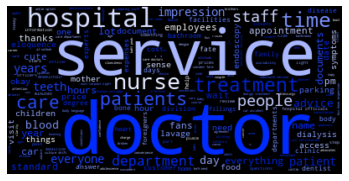

In [0]:
vizwordcloud(posPhyathai_1_predict, 'Blue')

เรียกใช้ function "vizwordcloud" เพื่อสร้าง word cloud ในกรณี positive ของโรงพยาบาล พญาไท 2 จากค่า predict

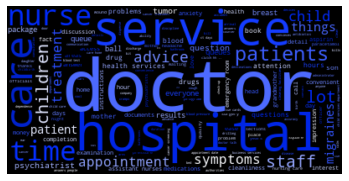

In [0]:
vizwordcloud(posPhyathai_2_predict, 'Blue')

เรียกใช้ function "vizwordcloud" เพื่อสร้าง word cloud ในกรณี positive ของโรงพยาบาล พญาไท 3 จากค่า predict

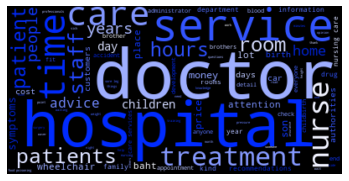

In [0]:
vizwordcloud(posPhyathai_3_predict, 'Blue')

เรียกใช้ function "vizwordcloud" เพื่อสร้าง word cloud ในกรณี negative ของโรงพยาบาล พญาไท 1 จากค่า predict

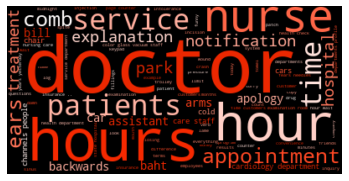

In [0]:
vizwordcloud(negPhyathai_1_predict, 'Red')

เรียกใช้ function "vizwordcloud" เพื่อสร้าง word cloud ในกรณี negative ของโรงพยาบาล พญาไท 2 จากค่า predict

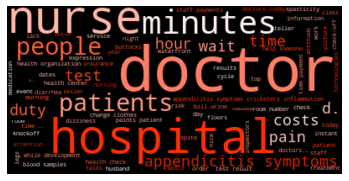

In [0]:
vizwordcloud(negPhyathai_2_predict, 'Red')

เรียกใช้ function "vizwordcloud" เพื่อสร้าง word cloud ในกรณี negative ของโรงพยาบาล พญาไท 3 จากค่า predict

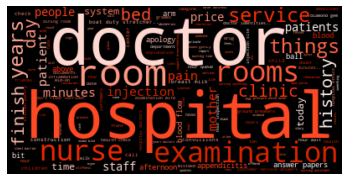

In [0]:
vizwordcloud(negPhyathai_3_predict, 'Red')

สร้าง function "wordGroups" เพื่อกรุ๊ปคำต่างๆ ให้อยู่ใน หมวดหมู้เดียวกัน เพื่อไปทำ radial chart

In [0]:
def wordGroups(word):
    if word in ("doctor", "nurse", "student"):
        return "staff"
    elif word in ("hospital", "clinic", "equipment", "place", "room", "system"):
        return "infrastructure"
    elif word in ("service", "care", "treatment", "surgery", "disease", "medical care", "park", "fillings", "explanation"):
        return "service"
    elif word in ("queue", "appointment", "time", "hour", "minutes", "appointment"):
        return "process"
    elif word in ("price", "claim"):
        return "finance"
    else:
        return "others"

เรียกใช้ function "wordGroups" ในทุกโรงพยาบาล

In [0]:
posPhyathai_1_predict["category"] = posPhyathai_1_predict["words"].apply(lambda x: wordGroups(x))
posPhyathai_1_predict = posPhyathai_1_predict.groupby("category").size().reset_index(name="#")
posPhyathai_1_predict = posPhyathai_1_predict[posPhyathai_1_predict["category"] != "others"].reset_index(drop=True)

posPhyathai_2_predict["category"] = posPhyathai_2_predict["words"].apply(lambda x: wordGroups(x))
posPhyathai_2_predict = posPhyathai_2_predict.groupby("category").size().reset_index(name="#")
posPhyathai_2_predict = posPhyathai_2_predict[posPhyathai_2_predict["category"] != "others"].reset_index(drop=True)

posPhyathai_3_predict["category"] = posPhyathai_3_predict["words"].apply(lambda x: wordGroups(x))
posPhyathai_3_predict = posPhyathai_3_predict.groupby("category").size().reset_index(name="#")
posPhyathai_3_predict = posPhyathai_3_predict[posPhyathai_3_predict["category"] != "others"].reset_index(drop=True)

negPhyathai_1_predict["category"] = negPhyathai_1_predict["words"].apply(lambda x: wordGroups(x))
negPhyathai_1_predict = negPhyathai_1_predict.groupby("category").size().reset_index(name="#")
negPhyathai_1_predict = negPhyathai_1_predict[negPhyathai_1_predict["category"] != "others"].reset_index(drop=True)

negPhyathai_2_predict["category"] = negPhyathai_2_predict["words"].apply(lambda x: wordGroups(x))
negPhyathai_2_predict = negPhyathai_2_predict.groupby("category").size().reset_index(name="#")
negPhyathai_2_predict = negPhyathai_2_predict[negPhyathai_2_predict["category"] != "others"].reset_index(drop=True)

negPhyathai_3_predict["category"] = negPhyathai_3_predict["words"].apply(lambda x: wordGroups(x))
negPhyathai_3_predict = negPhyathai_3_predict.groupby("category").size().reset_index(name="#")
negPhyathai_3_predict = negPhyathai_3_predict[negPhyathai_3_predict["category"] != "others"].reset_index(drop=True)

สร้าง function "radialChart" สำหรับสร้างกราฟ radial chart พร้อม save เป็น file HTML

In [0]:
def radialChart(data, hosNum, polarity, dataType):
  fig = px.line_polar(data, r="#", theta="category"
    , line_close=True, title="Phyathai " + hosNum + " " + polarity + " by " + dataType)
  fig.update_traces(fill='toself')
  fig.show()

  plot(fig, filename='Phyathai-' + hosNum + '_' + polarity + 'By' + dataType + '.html')

เรียกดูค่า positive ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 1

In [0]:
posPhyathai_1_predict

,category,#
0,finance,1
1,infrastructure,6
2,process,5
3,service,6
4,staff,2


เรียก function "radialChart" สร้างกราฟของค่า positive ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 1

In [0]:
radialChart(posPhyathai_1_predict, "1", "Positive", "predict")

เรียกดูค่า positive ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 2

In [0]:
posPhyathai_2_predict

,category,#
0,finance,1
1,infrastructure,4
2,process,4
3,service,5
4,staff,2


เรียก function "radialChart" สร้างกราฟของค่า positive ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 2

In [0]:
radialChart(posPhyathai_2_predict, "2", "Positive", "predict")

เรียกดูค่า positive ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 3

In [0]:
posPhyathai_3_predict

,category,#
0,finance,1
1,infrastructure,4
2,process,5
3,service,7
4,staff,2


เรียก function "radialChart" สร้างกราฟของค่า positive ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 3

In [0]:
radialChart(posPhyathai_3_predict, "3", "Positive", "predict")

เรียกดูค่า negative ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 1

In [0]:
negPhyathai_1_predict

,category,#
0,infrastructure,2
1,process,4
2,service,5
3,staff,2


เรียก function "radialChart" สร้างกราฟของค่า negative ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 1

In [0]:
radialChart(negPhyathai_1_predict, "1", "Negative", "predict")

เรียกดูค่า negative ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 2

In [0]:
negPhyathai_2_predict

,category,#
0,infrastructure,2
1,process,3
2,service,2
3,staff,2


เรียก function "radialChart" สร้างกราฟของค่า negative ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 2

In [0]:
radialChart(negPhyathai_2_predict, "2", "Negative", "predict")

เรียกดูค่า negative ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 3

In [0]:
negPhyathai_3_predict

,category,#
0,finance,1
1,infrastructure,5
2,process,4
3,service,2
4,staff,2


เรียก function "radialChart" สร้างกราฟของค่า negative ที่ใช้ค่า predict จากโรงพยาบาล พญาไท 3

In [0]:
radialChart(negPhyathai_3_predict, "3", "Negative", "predict")

---

# **Thank you**

# **กรกัญญา ศิริเกษ 62199130226**
# **อัจฉราภรณ์ สุขเพิ่ม 62199130379**
# **ทรงพล เกริกกิดาการ 62199130373**